In [26]:
import sys
sys.path.append('../')
import os
from functools import partial
from scipy import stats
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.linear_model import LinearRegression

import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.title_fontsize' : 5.5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff


# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

---
# Dimensionality vs. encoding performance

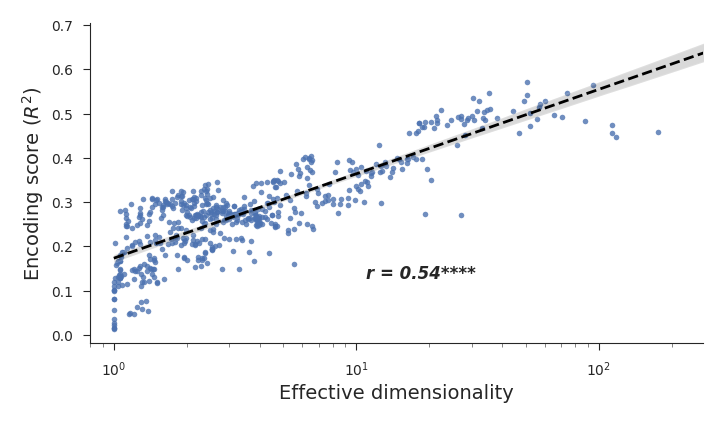

In [4]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

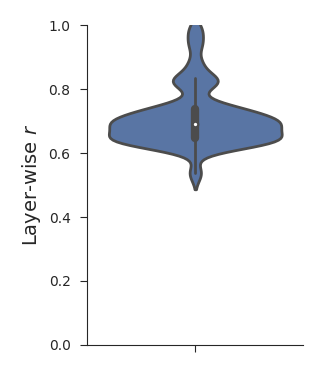

In [3]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/results_ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## By model kind

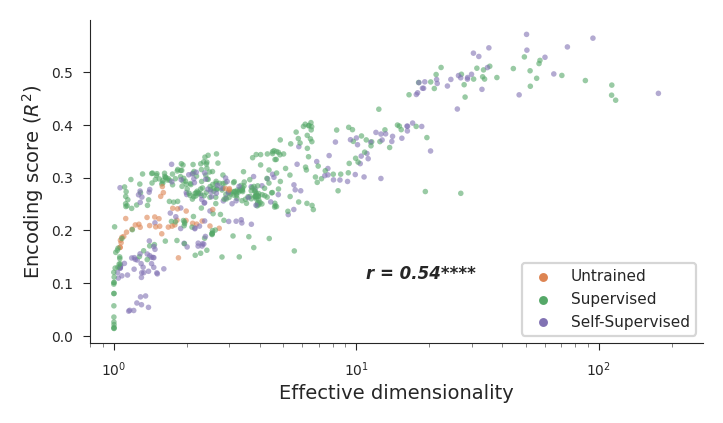

In [7]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.scatterplot(data=data, x='effective dimensionality', y='score',
                hue='kind', palette=(sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4]),
                alpha=0.6, s=4, linewidth=0,
                ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

ax.legend(loc='lower right')

plt.savefig('saved/results_bykind-ED-vs-encoding-all.png', dpi=300)
plt.show()

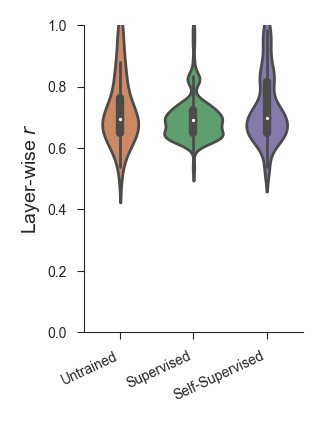

In [30]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 2))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1,
               x='kind', palette=(sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4]))
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

plt.savefig('saved/results_bykind-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

---
# Eigenspectrum vs. ED and & encoding performance

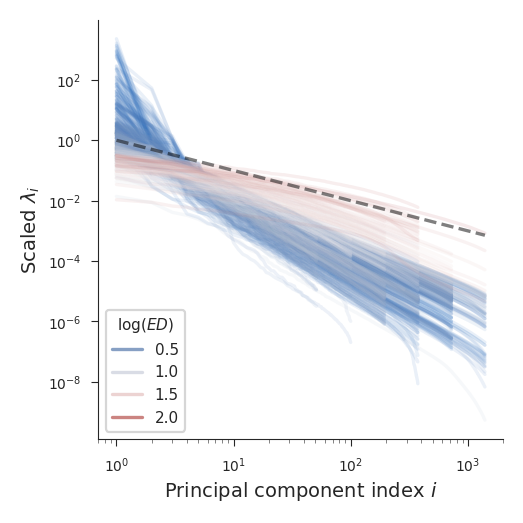

In [10]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'Principal component index $i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log')

ax.legend(title=r'$\log{(ED)}$', loc='lower left')

plt.savefig('saved/results_eigspectrum-vs-ed.png', dpi=300)
plt.show()

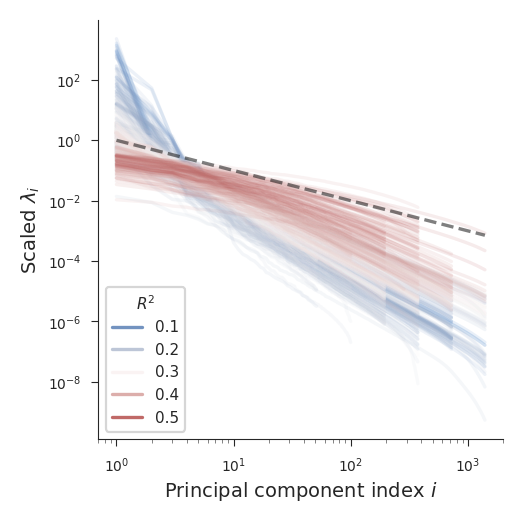

In [17]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

fig, ax = plt.subplots(figsize=(2.5, 2.5))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='score',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'Principal component index $i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log')

ax.legend(title=r'$R^2$', loc='lower left')

plt.savefig('saved/results_eigspectrum-vs-encoding.png', dpi=300)
plt.show()

---
# Effect of training

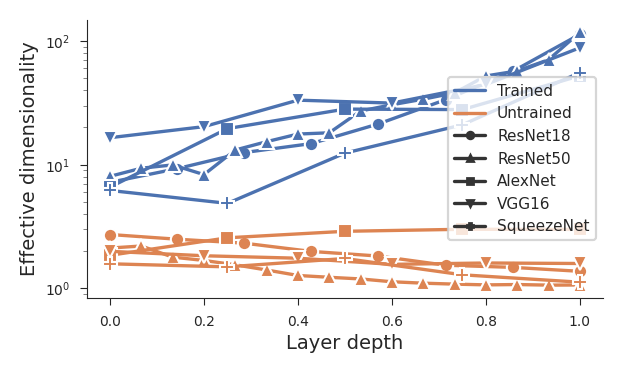

In [31]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
data_additional = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[data.source == 'PyTorch']

for arch in data.architecture.unique():
    arch_layers = data[data.architecture == arch].layer.unique()
    arch_depth = {layer: i / (len(arch_layers) - 1) for i, layer in enumerate(arch_layers)}
    data.loc[data.architecture == arch, 'depth'] = data.loc[data.architecture == arch, 'layer'].map(arch_depth)

fig, ax = plt.subplots(figsize=(3, 1.75))

sns.lineplot(data=data, x='depth', y='effective dimensionality', 
             hue='kind', style='architecture', markers=['o', '^', 's', 'v', 'P'], dashes=False,
             hue_order=['Supervised', 'Untrained'], style_order=['ResNet18', 'ResNet50', 'AlexNet', 'VGG16', 'SqueezeNet'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='Effective dimensionality', yscale='log')

handles, _ = ax.get_legend_handles_labels()
ax.legend(labels=['Trained', 'Untrained', 'ResNet18', 'ResNet50', 'AlexNet', 'VGG16', 'SqueezeNet'], 
          handles=handles[1:3] + handles[-5:])

plt.savefig('saved/results_factors-training-depth-architecture.png', dpi=300)
plt.show()

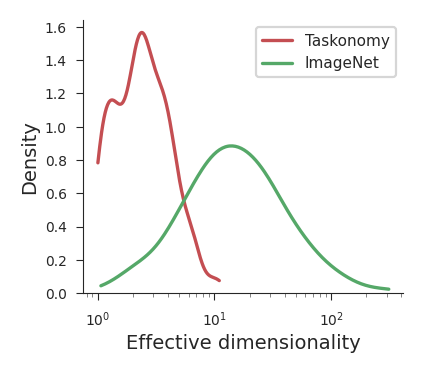

In [36]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
data_additional = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['dataset'] = data['source'].map({'PyTorch': 'ImageNet', 'Pytorch Hub': 'ImageNet', 'VVS': 'ImageNet', 'Taskonomy': 'Taskonomy'})
data = data[(data.kind != 'Untrained')]

fig, ax = plt.subplots(figsize=(2, 1.75))

sns.kdeplot(data=data, x='effective dimensionality', hue='dataset', 
            common_norm=False, cut=0, log_scale=True, 
            palette=sns.color_palette()[2:4], ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel='Density')

ax.legend(labels=['Taskonomy', 'ImageNet'])

plt.savefig('saved/results_factors-dataset-task.png', dpi=300)
plt.show()

---
# ZCA-whitened features

/opt/anaconda3/envs/brainscore/lib/python3.7/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


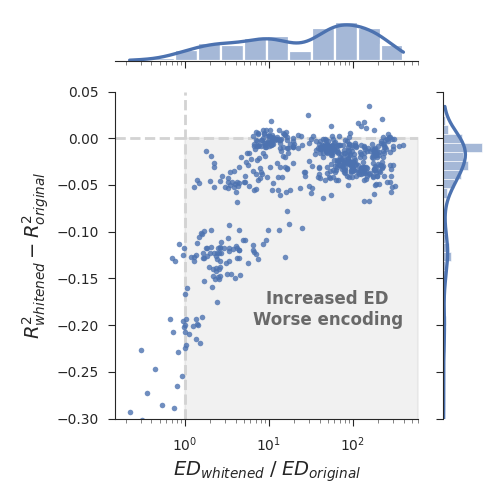

In [36]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:True.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:True|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data_zca = pd.merge(pd.read_csv(f'../../results/zca-counter-example|encoding.csv'),
                    pd.read_csv(f'../../results/zca-counter-example|eigmetrics.csv'), 
                    on=id_columns)
data_zca_additional = pd.merge(pd.read_csv(f'../../results/zca-counter-example|encoding|additional:True.csv'),
                               pd.read_csv(f'../../results/zca-counter-example|eigmetrics|additional:True.csv'),
                               on=id_columns)
data_zca = pd.concat([data_zca, data_zca_additional], ignore_index=True)
data_zca.loc[:, 'layer'] = data_zca['layer'].replace(tf_to_pt_layer_map)
assert (data.loc[:, id_columns]  == data_zca.loc[:, id_columns]).all(axis=None)

delta = pd.DataFrame()
delta['score'] = data_zca['score'] - data['score']
delta['effective dimensionality'] = data_zca['effective dimensionality'] / data['effective dimensionality'] # division because it will be logged

g = sns.JointGrid(height=2.5)
g.ax_joint.fill_between(x=[1, 600], y1=[-0.5, -0.5], y2=[0, 0], 
                        color='lightgrey', alpha=0.3)
g.ax_joint.axvline(1, color='lightgrey', linewidth=1, linestyle='--', zorder=-1)
g.ax_joint.axhline(0, color='lightgrey', linewidth=1, linestyle='--', zorder=-1)
g.ax_joint.text(50, -0.2, 'Increased ED\nWorse encoding', color='dimgray', weight='bold', ha='center')
sns.scatterplot(data=delta, x='effective dimensionality', y='score', 
                s=4, alpha=0.8, linewidth=0, ax=g.ax_joint)
sns.histplot(data=delta, x='effective dimensionality', 
             kde=True, log_scale=True, ax=g.ax_marg_x)
sns.histplot(data=delta, y='score', 
             kde=True, ax=g.ax_marg_y)
g.ax_joint.set(xlabel=r'$ED_{whitened} \; / \; ED_{original}$', ylabel=r'$R^2_{whitened} - R^2_{original}$', 
               xscale='log', xlim=(None, 600), ylim=(-0.3, 0.05))

plt.tight_layout()
plt.savefig('saved/results_zca-whitened.png', dpi=300)
plt.show()

---
# Trained with scrambled labels

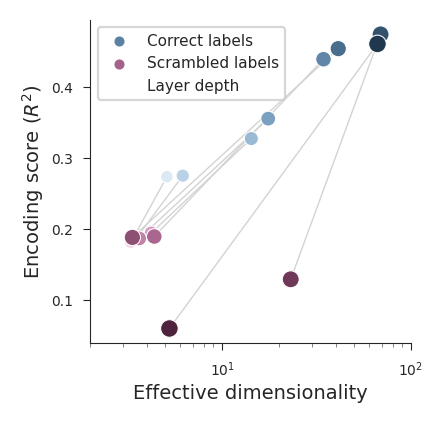

In [13]:
data = pd.merge(pd.read_csv(f'../../results/counter-example|encoding.csv'),
                pd.read_csv(f'../../results/counter-example|eigmetrics.csv'), 
                on=id_columns)

for arch in data.architecture.unique():
    arch_layers = data[data.architecture == arch].layer.unique()
    arch_depth = {layer: i / (len(arch_layers) - 1) for i, layer in enumerate(arch_layers)}
    data.loc[data.architecture == arch, 'depth'] = data.loc[data.architecture == arch, 'layer'].map(arch_depth)

fig, ax = plt.subplots(figsize=(2.1, 2))

palette_a = sns.cubehelix_palette(start=2.7, rot=0, light=0.9, dark=0.2, as_cmap=True)
palette_b = sns.cubehelix_palette(start=0.6, rot=0, light=0.9, dark=0.2, as_cmap=True)
sns.scatterplot(data=data[data.kind == 'Supervised'], x='effective dimensionality', y='score', 
                hue='depth', size='depth', sizes=(20, 40),
                palette=palette_a, ax=ax)
sns.scatterplot(data=data[data.kind == 'Supervised Random'], x='effective dimensionality', y='score', 
                hue='depth', size='depth', sizes=(20, 40),
                palette=palette_b, ax=ax)

for layer in data.layer.unique():
    layer_data = data[data.layer == layer]
    sns.lineplot(data=layer_data, x='effective dimensionality', y='score', 
                 linewidth=0.5, color='lightgrey', zorder=-1, ax=ax)

ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log', xlim=(2, 100))

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[handles[3], handles[9], Line2D([0], [0], color='white', lw=1.5)], 
          labels=['Correct labels', 'Scrambled labels', 'Layer depth'])

plt.savefig('saved/results_scrambled-labels-plot.png', dpi=300)
plt.show()

---
# Classification

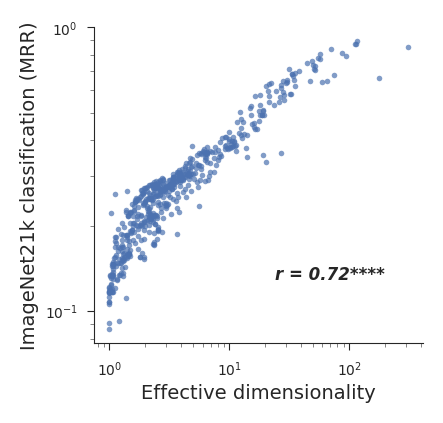

In [2]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg.csv')
data_additional = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg|additional:True.csv')
data = pd.concat([data, data_additional], ignore_index=True)
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet'
data_eig = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
data_additional = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
data_eig = pd.concat([data_eig, data_additional], ignore_index=True)
data = pd.merge(data, data_eig, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Effective dimensionality', ylabel='ImageNet21k classification (MRR)')
annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_classification-plot.png', dpi=300)
plt.show()

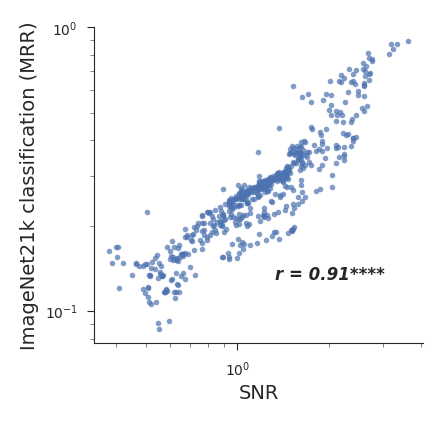

In [3]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg.csv')
data_additional = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg|additional:True.csv')
data = pd.concat([data, data_additional], ignore_index=True)
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet21k'
data_man = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv')
data_additional = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False|additional:True.csv')
data_man = pd.concat([data_man, data_additional], ignore_index=True)
data = pd.merge(data, data_man, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='signal-noise-ratio (mean)', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='SNR', ylabel='ImageNet21k classification (MRR)')
annotate_corr(data, x='signal-noise-ratio (mean)', y='MRR', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_classification-vs-snr-plot.png', dpi=300)
plt.show()

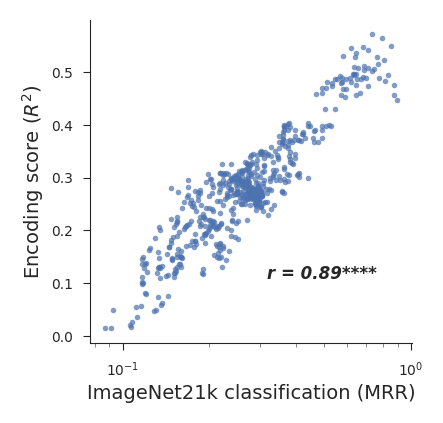

In [4]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg.csv')
data_additional = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:avg|additional:True.csv')
data = pd.concat([data, data_additional], ignore_index=True)
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

data_enc = pd.read_csv('../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv')
data_additional = pd.read_csv('../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv')
data_enc = pd.concat([data_enc, data_additional], ignore_index=True)
data = pd.merge(data, data_enc, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='MRR', y='score',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', xlabel='ImageNet21k classification (MRR)', ylabel=r'Encoding score ($R^2$)')
annotate_corr(data, x='MRR', y='score', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_classification-vs-encoding-plot.png', dpi=300)
plt.show()

---
# Projections

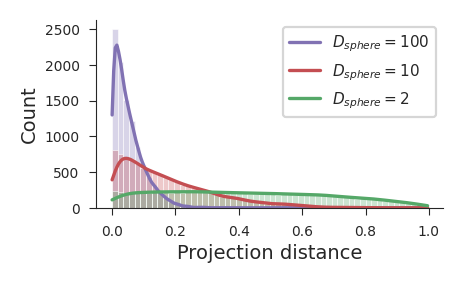

In [10]:
def get_samples(d, n, dist='ball'):
    assert dist in ['ball', 'gaussian']
    samples = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=n)
    if dist == 'ball':
        samples = samples / np.linalg.norm(samples, axis=1, keepdims=True)
        radii = np.random.random(size=(n, 1)) ** 0.5
        samples = samples * radii
    return samples

ds = [2, 10, 100]
n_samples = 10000
dist = 'ball'

if os.path.exists('data/projections_depiction.csv'):
    data = pd.read_csv('data/projections_depiction.csv')
else:
    np.random.seed(27)
    data = []
    for d in ds:
        samples = get_samples(d, n_samples, dist)
        projs = np.abs(samples[:, 0])    # Projection along unit vector (1, 0, 0, ...)
        for proj in projs:
            data.append({'projection': proj, 'dimensionality': d})
    data = pd.DataFrame(data)
    data.to_csv('data/projections_depiction.csv', index=False)
    
fig, ax = plt.subplots(figsize=(2.2, 1.3))

sns.histplot(data=data, x='projection', hue='dimensionality',
             alpha=0.3, palette=sns.color_palette()[2:5],
             kde=True, ax=ax)
ax.set(xlabel='Projection distance')

ax.legend(labels=[r'$D_{sphere} = 100$', 
                  r'$D_{sphere} = 10$', 
                  r'$D_{sphere} = 2$'])

plt.savefig('saved/results_projections-theoretical.png', dpi=300)
plt.show()

In [21]:
eigmetrics = pd.read_csv(f'../../results/eigmetrics|dataset:imagenet|pooling:avg|grayscale:False.csv')
projections = xr.open_dataarray(f'../../results/projections|dataset:imagenet21k|pooling:avg.nc')

eigmetrics.loc[:, 'layer'] = eigmetrics['layer'].replace(tf_to_pt_layer_map)
for source, target in tf_to_pt_layer_map.items():
    projections['layer'] = projections.layer.str.replace(source, target)

eigmetrics = eigmetrics.set_index(['architecture', 'task', 'kind', 'source', 'layer'])
eigmetrics = xr.DataArray(eigmetrics)
eigmetrics = eigmetrics.rename(dim_0='identifier', dim_1='eigmetric')
projections = projections.set_index(identifier=['architecture', 'task', 'kind', 'source', 'layer'])

data = xr.Dataset({'projections': projections, 
                   'eigmetrics': eigmetrics})
data = data.sortby(data.eigmetrics.sel(eigmetric='effective dimensionality'))
data['avg_projections'] = data.projections.mean(['source_category', 'target_category'])

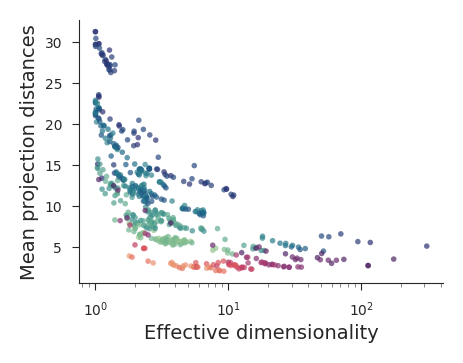

In [22]:
fig, ax = plt.subplots(figsize=(2.2, 1.7))

layer_normed_proj = data.avg_projections.sel(metric='scaled_projections').to_pandas()

resnet50 = data.sel(architecture='ResNet50', eigmetric='effective dimensionality', metric='scaled_projections')
resnet18 = data.sel(architecture='ResNet18', eigmetric='effective dimensionality', metric='scaled_projections')

sns.scatterplot(x=resnet50.eigmetrics.values,
                y=resnet50.avg_projections.values,
                hue=resnet50.layer.values,
                hue_order=sorted(resnet50.layer.values),
                palette=sns.color_palette('crest', n_colors=len(resnet50.layer)),
                alpha=0.7, s=4, linewidth=0, ax=ax)
sns.scatterplot(x=resnet18.eigmetrics.values,
                y=resnet18.avg_projections.values,
                hue=resnet18.layer.values,
                hue_order=sorted(resnet18.layer.values),
                palette=sns.color_palette('flare', n_colors=len(resnet18.layer)),
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', xlabel='Effective dimensionality', ylabel='Mean projection distances')

ax.legend().remove()

plt.savefig('saved/results_projections-mean.png', dpi=300)
plt.show()

Effective dimensionality (0): 1.19
Effective dimensionality (1): 6.56
Effective dimensionality (2): 94.67


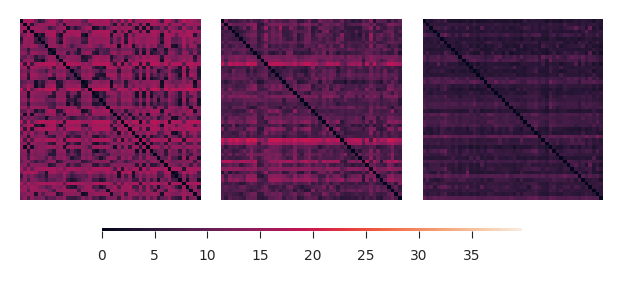

In [9]:
scaled_projections = data.projections.sel(metric='scaled_projections')
eigmetrics = data.eigmetrics.sel(eigmetric='effective dimensionality')
min_proj, max_proj = scaled_projections.min(), scaled_projections.max()

fig, axs = plt.subplots(1, 3, figsize=(3, 1.6))
cbar_ax = fig.add_axes([.15, 0.12, .7, .01])

for i, ratio in enumerate([0.1, 0.79, 0.99]):
    ratio = int(len(eigmetrics) * ratio)
    d = eigmetrics.isel(identifier=ratio).item()
    print(f'Effective dimensionality ({i}): {d:.2f}')
    projs = scaled_projections.isel(identifier=ratio)
    sns.heatmap(projs, xticklabels=[], yticklabels=[], 
                vmin=min_proj, vmax=max_proj, cbar_ax=cbar_ax, 
                cbar_kws={'orientation': 'horizontal'}, ax=axs[i])
    axs[i].set(box_aspect=1)

plt.savefig('saved/results_projections-examples.png', dpi=300)
plt.show()

---
# Appendix - Dimensionality vs. encoding performance

## No spatial pooling

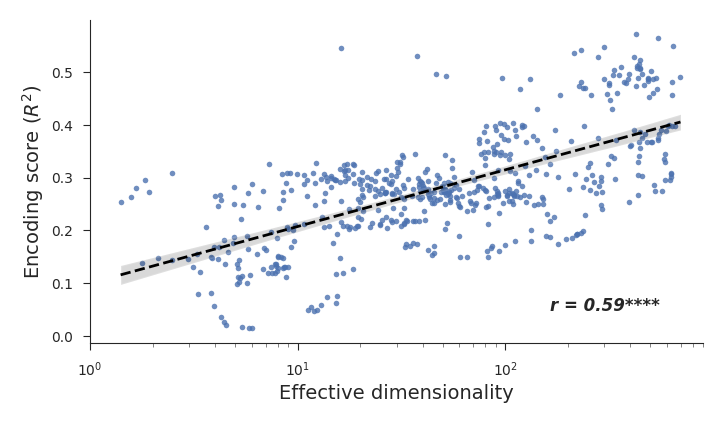

In [40]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:none|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(1, 900)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.75, 0.1), ax=ax)

plt.savefig('saved/appendix_nopool-ED-vs-encoding-all.png', dpi=300)
plt.show()

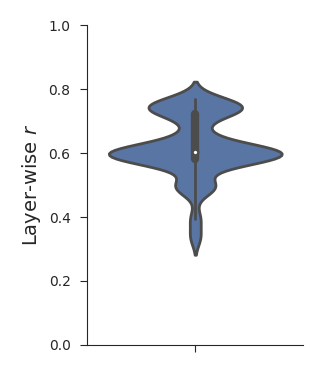

In [10]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_nopool-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## Object2Vec

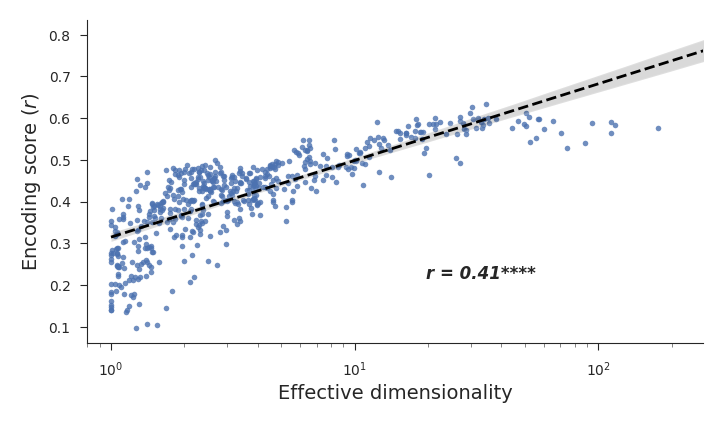

In [43]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($r$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/appendix_object2vec-ED-vs-encoding-all.png', dpi=300)
plt.show()

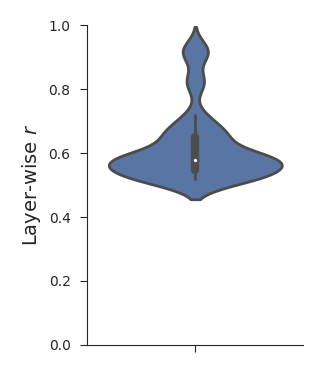

In [29]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_object2vec-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## Outliers and additional PCs

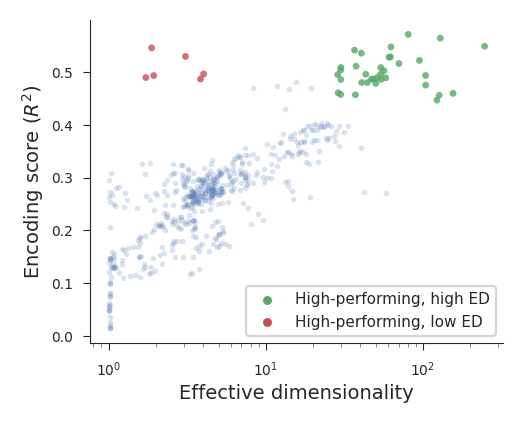

In [8]:
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:imagenet|pooling:True|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

performant = (data['score'] > 0.43)
control = performant & (data['effective dimensionality'] > 20)
outlier = performant & (data['effective dimensionality'] < 8)
data['group'] = 'Other'
data.loc[control, 'group'] = 'Control'
data.loc[outlier, 'group'] = 'Outlier'

control = data[control][id_columns].reset_index(drop=True)
outlier = data[outlier][id_columns].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.scatterplot(data=data[data.group == 'Other'], x='effective dimensionality', y='score',
                alpha=0.2, s=4, linewidth=0, ax=ax)
sns.scatterplot(data=data[data.group != 'Other'], x='effective dimensionality', y='score',
                hue='group', alpha=0.8, s=6, linewidth=0,
                palette=sns.color_palette()[2:4], ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')

handles, _ = ax.get_legend_handles_labels()
ax.legend(labels=['High-performing, high ED', 'High-performing, low ED'], 
          handles=handles)

plt.savefig('saved/appendix_dimusage-models.png', dpi=300)
plt.show()

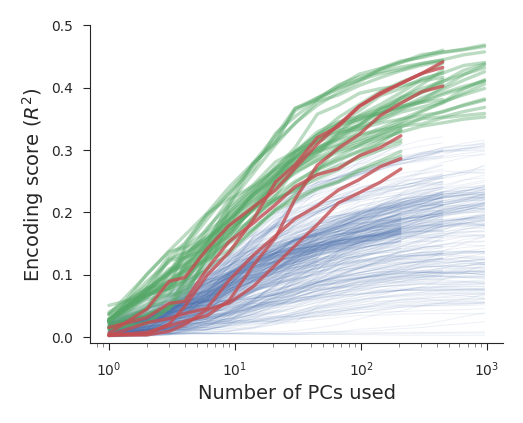

In [10]:
scaled = False
norm_pc = 207

data = pd.read_csv(f'../../results/dimusage|benchmark:majajhong2015|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def isin_group(groupdf, row):
    row = row[id_columns]
    return (row == groupdf).all(axis='columns').sum().astype(bool)

data['control'] = data.apply(partial(isin_group, control), axis='columns')
data['outlier'] = data.apply(partial(isin_group, outlier), axis='columns')
# data = data[data.control | data.outlier]
data['id'] = data[id_columns].sum(axis='columns')

if scaled:
    scaled_scores = data.groupby(id_columns).apply(lambda x: x.scores / x[x.num_pcs == norm_pc].scores.item())
    scaled_scores = scaled_scores.reset_index(id_columns, drop=True)
    data['scaled_scores'] = scaled_scores
    y, ylabel = 'scaled_scores', r'Scaled encoding score ($R^2$)'
else:
    y, ylabel = 'scores', r'Encoding score ($R^2$)'

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.lineplot(data=data[(~data.outlier) & (~data.control)], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.1, linewidth=0.35,
             color=sns.color_palette()[0], ax=ax)
sns.lineplot(data=data[data.control], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.4,
             color=sns.color_palette()[2], ax=ax)
sns.lineplot(data=data[data.outlier], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.8,
             color=sns.color_palette()[3], ax=ax)
ax.set(xlabel='Number of PCs used', ylabel=ylabel, xscale='log',
       ylim=(-0.01, 0.5))

plt.savefig('saved/appendix_dimusage-trends.png', dpi=300)
plt.show()

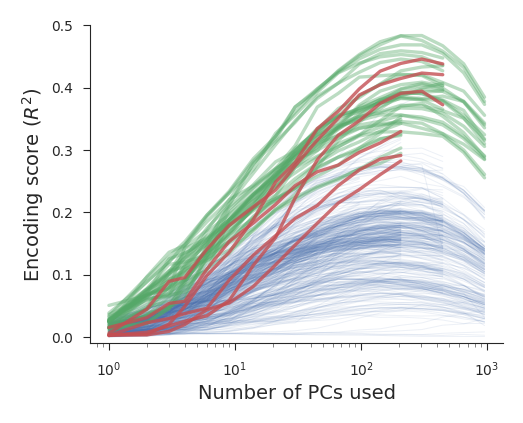

In [9]:
scaled = False
norm_pc = 207

data = pd.read_csv(f'../../results/dimusage|benchmark:majajhong2015|reg:lin|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def isin_group(groupdf, row):
    row = row[id_columns]
    return (row == groupdf).all(axis='columns').sum().astype(bool)

data['control'] = data.apply(partial(isin_group, control), axis='columns')
data['outlier'] = data.apply(partial(isin_group, outlier), axis='columns')
# data = data[data.control | data.outlier]
data['id'] = data[id_columns].sum(axis='columns')

if scaled:
    scaled_scores = data.groupby(id_columns).apply(lambda x: x.scores / x[x.num_pcs == norm_pc].scores.item())
    scaled_scores = scaled_scores.reset_index(id_columns, drop=True)
    data['scaled_scores'] = scaled_scores
    y, ylabel = 'scaled_scores', r'Scaled encoding score ($R^2$)'
else:
    y, ylabel = 'scores', r'Encoding score ($R^2$)'

fig, ax = plt.subplots(figsize=(2.5, 2))

sns.lineplot(data=data[(~data.outlier) & (~data.control)], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.1, linewidth=0.35,
             color=sns.color_palette()[0], ax=ax)
sns.lineplot(data=data[data.control], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.4,
             color=sns.color_palette()[2], ax=ax)
sns.lineplot(data=data[data.outlier], x='num_pcs', y=y,
             units='id', estimator=None, alpha=0.8,
             color=sns.color_palette()[3], ax=ax)
ax.set(xlabel='Number of PCs used', ylabel=ylabel, xscale='log',
       ylim=(-0.01, 0.5))

plt.savefig('saved/appendix_dimusage-trends-lin.png', dpi=300)
plt.show()

## All regions

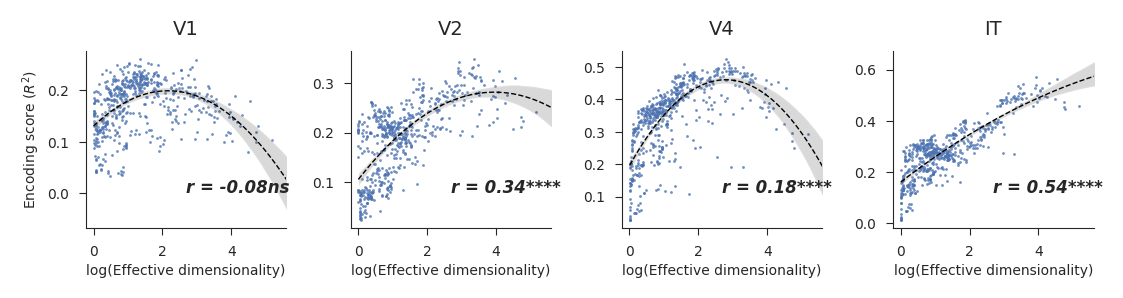

In [47]:
regions = ['V1', 'V2', 'V4', 'IT']
dataset = 'imagenet'
eigmetrics = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
eigspectra = pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False.csv')
eigmetrics_additional = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
eigspectra_additional = pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
eigspectra = pd.concat([eigspectra, eigspectra_additional], ignore_index=True)
eigmetrics = pd.concat([eigmetrics, eigmetrics_additional], ignore_index=True)

fig, axs = plt.subplots(1, len(regions), figsize=(5.5, 5.5 / len(regions)))

for i, region in enumerate(regions):
    if region in ['V1', 'V2']:
        bench_name = f'movshon.FreemanZiemba2013.{region}.public-pls'
    else:
        bench_name = f'dicarlo.MajajHong2015.{region}.public-pls'
    bench = pd.read_csv(f'../../results/encoding|benchmark:{bench_name}|pooling:False.csv')
    bench_additional = pd.read_csv(f'../../results/encoding|benchmark:{bench_name}|pooling:False|additional:True.csv')
    bench = pd.concat([bench, bench_additional], ignore_index=True)
    
    # ED vs. encoding
    data = pd.merge(eigmetrics, bench, on=id_columns)
    data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
    data["logED"] = np.log(data["effective dimensionality"])
    
    ax = axs[i]

    ax.set_xlim(np.log(0.8), np.log(270))
    sns.regplot(data=data, x='logED', y='score', 
                logx=False, order=2,
                scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 0.5}, 
                ax=ax)
    ax.set(title=region)
    ax.set_xlabel('log(Effective dimensionality)', fontsize=5)
    if i == 0:
        ax.set_ylabel(r'Encoding score ($R^2$)', fontsize=5)
    else:
        ax.set_ylabel(None)
    annotate_corr(data, x='effective dimensionality', y='score', pos=(0.5, 0.2), ax=ax)
    
    # Eigenspectra vs. encoding
    # data = pd.merge(eigspectra, bench, on=id_columns)
    # data["task"] = data["task"].fillna("None")
    # data['id'] = data[id_columns].sum(axis='columns')

    # outlier = data.groupby(id_columns)['n'].transform(is_outlier)
    # data = data[~outlier]

    # scaled_var = data.groupby(id_columns).apply(get_scaled_var)
    # scaled_var = scaled_var.reset_index(id_columns, drop=True)
    # data['scaled_variance'] = scaled_var

    # ax = axs[1, i]

    # sns.lineplot(data=data, x='n', y='scaled_variance', hue='score',
    #              units='id', alpha=0.1, linewidth=0.4, estimator=None,
    #              palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
    # ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
    # ax.set(xscale='log', yscale='log')
    # ax.set_xlabel(r'$i$', fontsize=5)
    # if i == 0:
    #     ax.set_ylabel(r'Scaled $\lambda_i$', fontsize=5)
    # else:
    #     ax.set_ylabel(None)

    # ax.legend(title=r'$R^2$', loc='upper right', fontsize=4, title_fontsize=5, ncol=2)

plt.savefig('saved/appendix_allregions-neurophysiology.png', dpi=300)
plt.show()

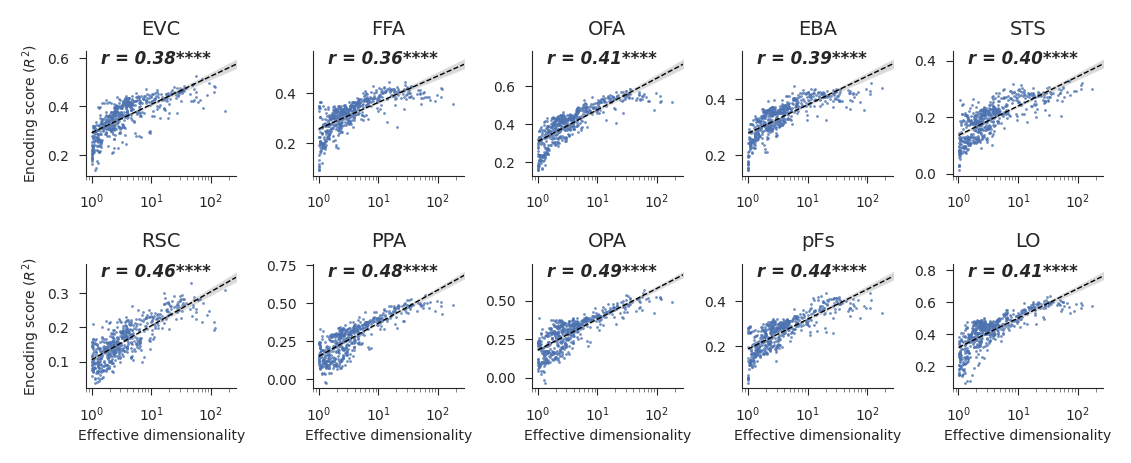

In [56]:
all_regions = [['EVC', 'FFA', 'OFA', 'EBA', 'STS'], ['RSC', 'PPA', 'OPA', 'PFS', 'LOC']]
dataset = 'imagenet'
eigmetrics = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv')
eigspectra = pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False.csv')
eigmetrics_additional = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
eigspectra_additional = pd.read_csv(f'../../results/eigspectra|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv')
eigspectra = pd.concat([eigspectra, eigspectra_additional], ignore_index=True)
eigmetrics = pd.concat([eigmetrics, eigmetrics_additional], ignore_index=True)

fig, axs = plt.subplots(2, len(all_regions[0]), figsize=(5.5, 5.5 / 5 * 2))
    
for k, regions in enumerate(all_regions):
    for i, region in enumerate(regions):
        bench = pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi={region}|pooling:False.csv')
        bench_additional = pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi={region}|pooling:False|additional:True.csv')
        bench = pd.concat([bench, bench_additional], ignore_index=True)
        
        # ED vs. encoding
        data = pd.merge(eigmetrics, bench, on=id_columns)
        data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
        
        ax = axs[k, i]

        ax.set_xlim(0.8, 270)
        sns.regplot(data=data, x='effective dimensionality', y='score', 
                    logx=True,
                    scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
                    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 0.5}, 
                    ax=ax)
        ax.set(title=region.replace('LOC', 'LO').replace('PFS', 'pFs'), xscale='log')
        if k == 0:
            ax.set_xlabel(None)
        else:
            ax.set_xlabel('Effective dimensionality', fontsize=5)
        if i == 0:
            ax.set_ylabel(r'Encoding score ($R^2$)', fontsize=5)
        else:
            ax.set_ylabel(None)
        annotate_corr(data, x='effective dimensionality', y='score', pos=(0.1, 0.9), ax=ax)
        
        # Eigenspectra vs. encoding
        # data = pd.merge(eigspectra, bench, on=id_columns)
        # data["task"] = data["task"].fillna("None")
        # data['id'] = data[id_columns].sum(axis='columns')

        # outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        # data = data[~outlier]

        # scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        # scaled_var = scaled_var.reset_index(id_columns, drop=True)
        # data['scaled_variance'] = scaled_var

        # ax = axs[1, i]

        # sns.lineplot(data=data, x='n', y='scaled_variance', hue='score',
        #             units='id', alpha=0.1, linewidth=0.4, estimator=None,
        #             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        # ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5, linewidth=0.5)
        # ax.set(xscale='log', yscale='log')
        # ax.set_xlabel(r'$i$', fontsize=5)
        # if i == 0:
        #     ax.set_ylabel(r'Scaled $\lambda_i$', fontsize=5)
        # else:
        #     ax.set_ylabel(None)

        # ax.legend(title=r'$R^2$', loc='upper right', fontsize=4, title_fontsize=5, ncol=2)

plt.savefig(f'saved/appendix_allregions-fMRI.png', dpi=300)
plt.show()

## By training dataset

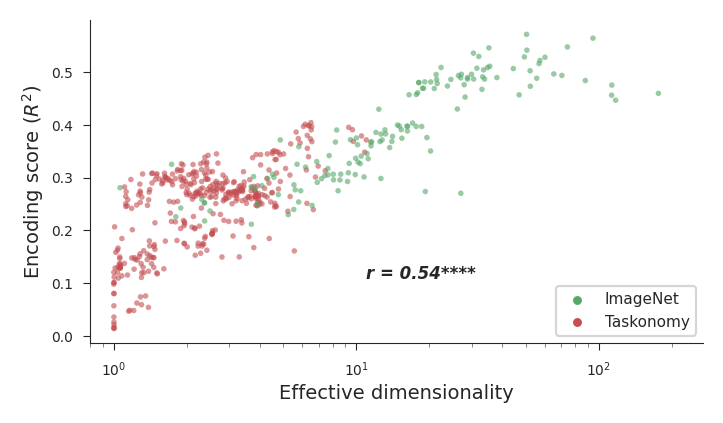

In [57]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['dataset'] = data['source'].map({'PyTorch': 'ImageNet', 'Pytorch Hub': 'ImageNet', 'VVS': 'ImageNet', 'Taskonomy': 'Taskonomy'})
data = data[(data.kind != 'Untrained')]
data = pd.concat([data[data.dataset == "Taskonomy"], data[data.dataset == "ImageNet"]])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.scatterplot(data=data, x='effective dimensionality', y='score',
                hue='dataset', hue_order=["ImageNet", "Taskonomy"], palette=sns.color_palette()[2:4],
                alpha=0.6, s=4, linewidth=0,
                ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

ax.legend(loc='lower right')

plt.savefig('saved/appendix_ED-vs-encoding-all-dataset.png', dpi=300)
plt.show()

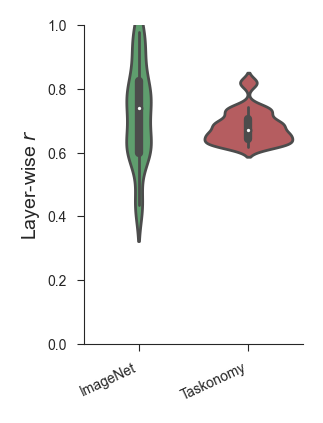

In [17]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['dataset'] = data['source'].map({'PyTorch': 'ImageNet', 'Pytorch Hub': 'ImageNet', 'VVS': 'ImageNet', 'Taskonomy': 'Taskonomy'})
data = data[(data.kind != 'Untrained')]

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 2))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1,
               x='dataset', palette=sns.color_palette()[2:5])
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

plt.savefig('saved/appendix_ED-vs-encoding-layerwise-dataset.png', dpi=300)
plt.show()

## RSA

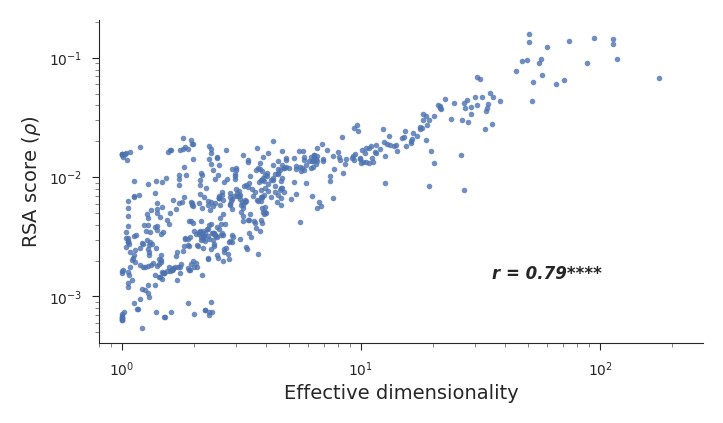

In [7]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/rsa|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/rsa|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.scatterplot(data=data, x='effective dimensionality', y='score',
                alpha=0.8, s=4, linewidth=0, ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'RSA score ($\rho$)', xscale='log', yscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.65, 0.2), ax=ax)

plt.savefig('saved/appendix_ED-vs-RSA-all.png', dpi=300)
plt.show()

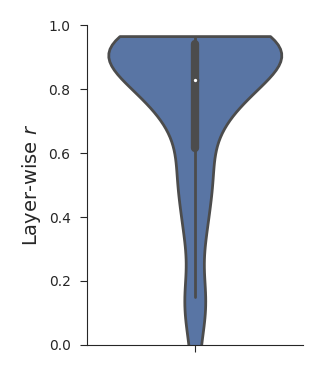

In [33]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/rsa|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', cut=0, ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_ED-vs-RSA-layerwise.png', dpi=300)
plt.show()

---
# OLS

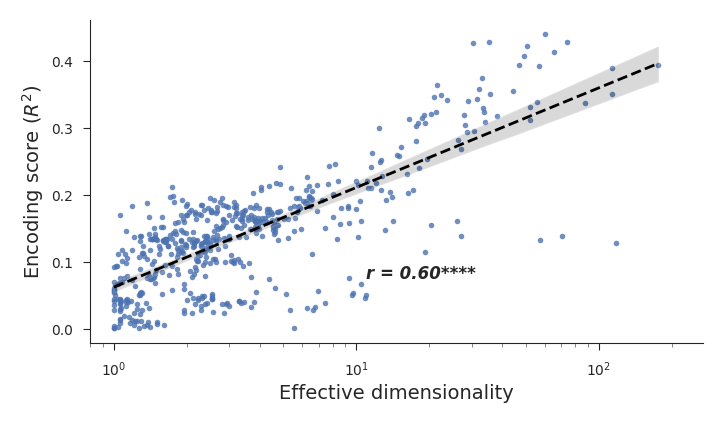

In [4]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-lin|pooling:True.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-lin|pooling:True|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'), 
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

plt.savefig('saved/appendix_ED-vs-encoding-all-OLS.png', dpi=300)
plt.show()

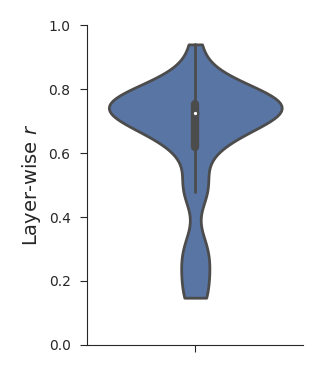

In [37]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-lin|pooling:True.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', cut=0, ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_ED-vs-encoding-layerwise-OLS.png', dpi=300)
plt.show()

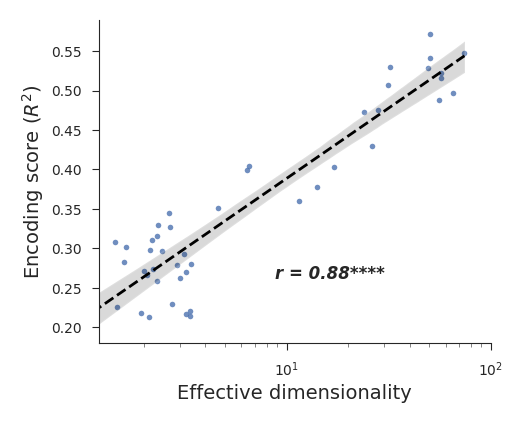

In [67]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:avg|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data.groupby(list(set(id_columns) - {'layer'})).apply(lambda x: x.nlargest(1, 'score'))

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

ax.set_xlim(1.2, 100)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

plt.savefig('saved/appendix_ED-vs-encoding-bestlayer-pooled.png', dpi=300)
plt.show()

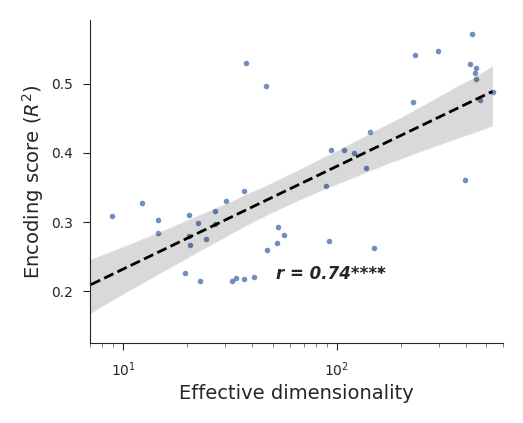

In [69]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:none|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data.groupby(list(set(id_columns) - {'layer'})).apply(lambda x: x.nlargest(1, 'score'))

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

ax.set_xlim(7, 600)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=ax)

plt.savefig('saved/appendix_ED-vs-encoding-bestlayer-nopooling.png', dpi=300)
plt.show()

---
## Competing manifold statistics

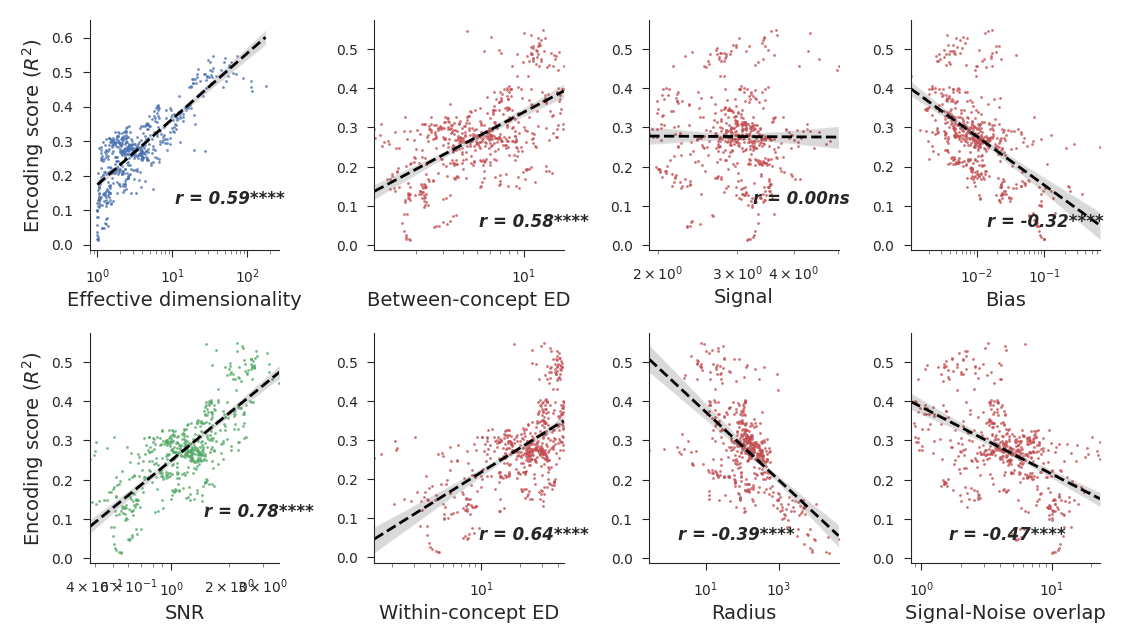

In [25]:
dataset = 'imagenet21k'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv'), 
                on=id_columns)
data = pd.merge(data, 
                pd.read_csv(f'../../results/eigmetrics|dataset:imagenet|pooling:avg|grayscale:False.csv'), 
                on=id_columns)
data_additional = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False|additional:True.csv'),
                           pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False|additional:True.csv'),
                           on=id_columns)
data_additional = pd.merge(data_additional,
                           pd.read_csv(f'../../results/eigmetrics|dataset:imagenet|pooling:avg|grayscale:False|additional:True.csv'),
                           on=id_columns)
data = pd.concat([data, data_additional], ignore_index=True)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(2, 4, figsize=(5.5, 3.1))

axs[0, 0].set_xlim(0.8, 270)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0, 0])
axs[0, 0].set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.45, 0.2), ax=axs[0, 0])

sns.regplot(data=data, x='signal-noise-ratio (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[2],
            ax=axs[1, 0])
axs[1, 0].set(xlabel='SNR', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='signal-noise-ratio (mean)', y='score', pos=(0.6, 0.2), ax=axs[1, 0])

sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[0, 1])
axs[0, 1].set(xlabel='Between-concept ED', ylabel=None, xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.55, 0.1), ax=axs[0, 1])

sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[1, 1])
axs[1, 1].set(xlabel='Within-concept ED', ylabel=None, xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.55, 0.1), ax=axs[1, 1])

sns.regplot(data=data, x='signal (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[0, 2])
axs[0, 2].set(xlabel='Signal', ylabel=None, xscale='log')
annotate_corr(data, x='signal (mean)', y='score', pos=(0.55, 0.2), ax=axs[0, 2])

sns.regplot(data=data, x='bias (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[0, 3])
axs[0, 3].set(xlabel='Bias', ylabel=None, xscale='log')
annotate_corr(data, x='bias (mean)', y='score', pos=(0.4, 0.1), ax=axs[0, 3])

sns.regplot(data=data, x='within-concept radius (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[1, 2])
axs[1, 2].set(xlabel='Radius', ylabel=None, xscale='log')
annotate_corr(data, x='within-concept radius (mean)', y='score', pos=(0.15, 0.1), ax=axs[1, 2])

sns.regplot(data=data, x='self signal-noise-overlap (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 1, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1},
            color=sns.color_palette()[3],
            ax=axs[1, 3])
axs[1, 3].set(xlabel='Signal-Noise overlap', ylabel=None, xscale='log')
annotate_corr(data, x='self signal-noise-overlap (mean)', y='score', pos=(0.2, 0.1), ax=axs[1, 3])

plt.savefig('saved/results_competing-vs-encoding.png', dpi=300)
plt.show()